<a href="https://colab.research.google.com/github/diidouu/SLAM-PROJECT/blob/main/projectRobotic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bayesian Filtering Project : Simultaneous SLAM (Localization and Cartography) - EKF**
# 1. Problem definition :
The SLAM challenge can be seen as the *'chicken and egg problem'* :


*   To build a precise map of an unknown environment, a robot must know its position at each instant.
*   To locate itself with precision, a robot needs a precise map of the environment he is in.

SLAM consists in resolving these two problems in the same time. So, the goal is to estimate in real time an ***augmented state*** that contains :


*   The position and orientation of the robot (𝑥, 𝒚, θ)
*   The position of all static landmarks that the robot discovered ( (lx1,ly1), (lx2, ly2), ..).

This problem will be tackled with a 2D simulation in which a robot is equipped with captors that allow the robot to measure distance and angle with the landmark (this measures will be in interference with noise).

# 2. Algorithm and Development environment :

To resolve this non-linear estimation problem (trigonometry in movement and observation models are non-linear), we will use the ***Extended Kalman Filter (EKF)***. It is based on cycles of *Prediction - Correction* :


*   *Prediction* : The robot moves. Its new position is predicted thanks to the movement model. However, the likelihood decreases.
*   *Correction* : The robot observes one or several landmarks. This observation is used to correct the estimated position of the robot and landmarks in the *Prediction step.* If a new landmark is discovered, the map is dynamically extended. Thus, the likelihood increases.

The system state is described by a Gaussian distribution, defined by a state vector *μ* (this vector contains position and orientation of the landmarks) and a covariance matrix Σ that contains the likelihood and correlations between all state variables.

This project is developped in *Python3* in a *Google Colab notebook*. This environment has been chosen because of its set up simplicity and its visualization tools. The main libraries used are :


*   Numpy
*   Matplotlib





# **Step 1 - Creation of the virtual world and the simulation**
# Objective
Before estimating whatever we want, we need a perfect simulated environment with no noise. This environment will be our ***ground truth***. It will be our absolute reference which we will compare our filter's estimations performance with.
# Key components


1.   ***Landmarks*** : these are static points in our world. They will be really useful for localization. We define them as coordinates list (𝑥,𝑦).
2.   ***True trajectory of the robot*** : It is the exact path that the robot follows. We generate it by applying a perfect cinematic movement model thanks to control commands (linear velocity 𝑣 and angular velocity ω).
3. ***Perfect measures of captors*** : We simulate what captors would measure in an ideal situation/world. For each landmark, we calculate the exact euclidean distance and angle (with respect to the robot) by using simple geometric relations such *sqrt* and *arctan2*.

The visualization of these key components will give us a clear view of the simulation in which our EKF-SLAM will try to reconstruct from noisy data.



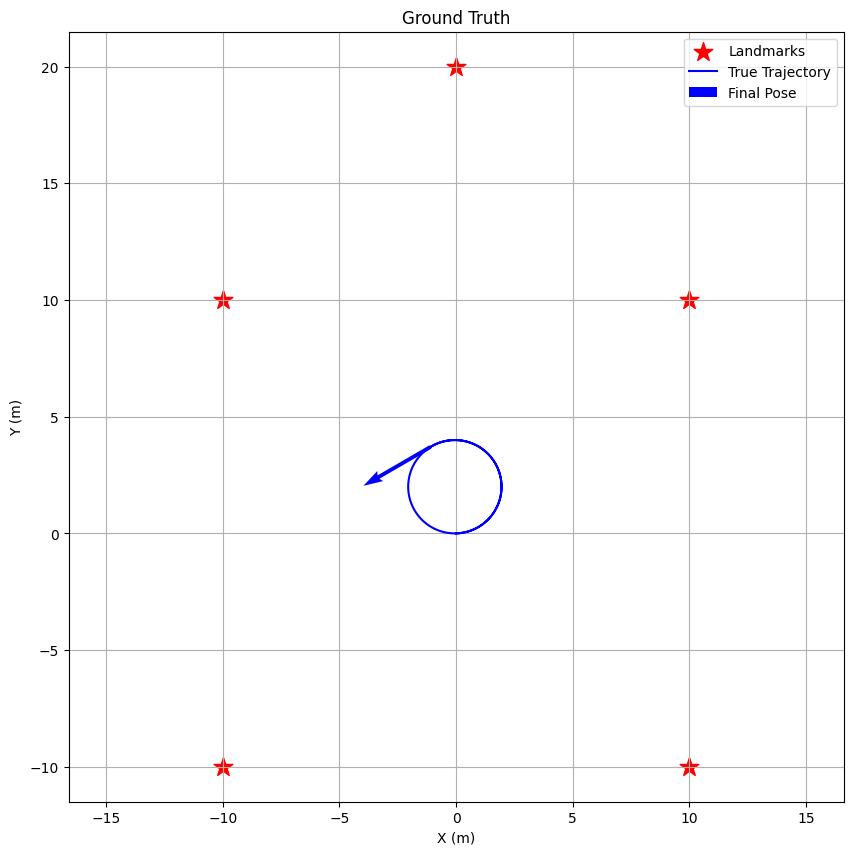

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1.1. Definition of landmarks position ---
# These are our reference points in the world.

landmarks = np.array([
    [10.0,10.0],
    [10.0,-10.0],
    [-10.0,10.0],
    [-10.0,-10.0],
    [0,20.0]
])


# --- 1.2. Definition of the true trajectory of the robot (Ground truth) ---
# This is the perfect path that the robot follows.

# Simulation parameters
dt = 0.1  # time interval (seconds)
SIMULATION_TIME = 20.0  # total duration of the simulation
NUM_STEPS = int(SIMULATION_TIME / dt)  # total number of simulation steps

# Trajectory storage
true_path = np.zeros((NUM_STEPS , 3))  # each line is [x , y , theta]
# initial position is (0 , 0 , 0)

# Constant control commands to create a circular trajectory
v = 1.0  # constant linear velocity (m/s)
omega = 0.5  # constant angular velocity (rad/s)

# Trajectory generation step by step
for t in range (1, NUM_STEPS):

  # Recover precedent position
  prev_x, prev_y, prev_theta = true_path[t-1]

  # Apply perfect cinematic movement model
  theta = prev_theta + omega * dt
  x = prev_x + v * np.cos(theta) * dt
  y = prev_y + v * np.sin(theta) * dt

  # Stock new true position
  true_path[t] = [x,y,theta]


  # --- 1.3. Simulation of the captors'perfect measures ---

  def get_true_measurement(robot_pose , landmarks) :

    """
    Calculate the perfect distance and angle of the robot to each landmarks
    """

    measurements = []
    rx , ry , rtheta = robot_pose

    for landmark in landmarks :
      lx, ly = landmark

      # Euclidean distance
      dist = np.sqrt((lx - rx)**2 + (ly - ry)**2)

      # Angle to the landmark
      angle_to_landmark = np.arctan2(ly - ry, lx - rx)

      # Angle of the robot orientation (Bearing)
      bearing = angle_to_landmark - rtheta

      # Normalization of the bearing angle so it is in [-pi , +pi]
      bearing = (bearing + np.pi) % (2 * np.pi) - np.pi

      measurements.append([dist , bearing])

    return np.array(measurements)


# --- 1.4. Visualisation du monde simulé ---

def plot_world(path , lanfdmarks) :
  plt.figure(figsize=(10, 10))
  plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='*', s=200, color='red', label='Landmarks')
  plt.plot(path[:, 0], path[:, 1], 'b-', label='True Trajectory')

  # Draw an arrow to show final orientation of the robot
  final_pose = path[-1]
  plt.quiver(final_pose[0], final_pose[1], np.cos(final_pose[2]), np.sin(final_pose[2]),
               color='blue', scale=10, width=0.005, label='Final Pose')

  plt.xlabel('X (m)')
  plt.ylabel('Y (m)')
  plt.title('Ground Truth')
  plt.grid(True)
  plt.axis('equal')
  plt.legend()
  plt.show()

# Display the world
plot_world(true_path , landmarks)

# **Step 2 : Uncertainties modelisation**
# Objective

Make our simulation as much realist as possible. In real life, actions and perceptions of the robot are imperfect. We will simulate these imperfections by introducing two types of *Gaussian noises* :



*   *Movement noise (on controls)* : Motors are not perfect. When a speed control is sent to the robot, it doesnt execute it perfectly. This provokes a position drift (the position which is estimated by odometry). We will simulate this by adding noises to the speed commands 𝑣 and ω.
*   *Measure noise (on captors)* : captors such as lasers, camera are not perfect. They provide measures with a certain amount of error. We will simulate this by adding

